In [1]:
import numpy as np 
import pandas as pd 
from scipy.stats import pearsonr 
import matplotlib.pyplot as plt 

import world_values_utils as ut

%matplotlib notebook 

In [2]:
values_train, hdi_train, values_test = ut.import_world_values_data() 


In [3]:
corrs = ut.calculate_correlations(values_train, hdi_train)

Action taken on climate change 0.47331289154299033
Better transport and roads -0.43963363862245863
Support for people who can't work -0.33621323672149067
Access to clean water and sanitation -0.018169084455954734
Better healthcare -0.4220123599593434
A good education -0.30397888977158355
A responsive government we can trust 0.32944531498417795
Phone and internet access -0.3516047121577416
Reliable energy at home -0.2854235638359744
Affordable and nutritious food 0.19519330078603303
Protecting forests rivers and oceans 0.6134587562712408
Protection against crime and violence 0.14331869917957565
Political freedoms 0.23809900682145022
Freedom from discrimination and persecution 0.4329323754445626
Equality between men and women 0.27649604349752843
Better job opportunities -0.3973445267396408
[0.4733, -0.4396, -0.3362, -0.0182, -0.422, -0.304, 0.3294, -0.3516, -0.2854, 0.1952, 0.6135, 0.1433, 0.2381, 0.4329, 0.2765, -0.3973]



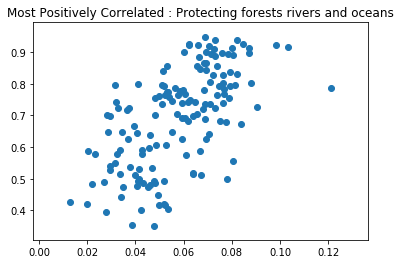

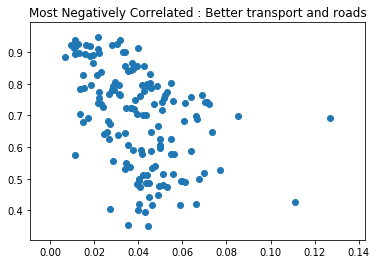

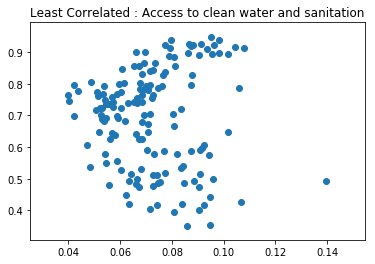

In [25]:
feature_headers = list(values_train)
f_indices = [np.argmax(corrs), np.argmin(corrs), np.argmin(np.absolute(corrs))]
name = ['Most Positively Correlated', 'Most Negatively Correlated','Least Correlated']
j = 0 
for i in f_indices :
    
    plt.figure() 
    plt.title(name[j] + ' : ' + feature_headers[i])
    plt.scatter(values_train[feature_headers[i]], np.array(hdi_train).astype(float))
    j = j + 1 

There is no clear correlation, or trend line. However, there is a different density of points as we increase or decrease HDI, which might account for the mathmatical correlation we are finding. The most uncorrelated feature seems to have the homogeneous density in the HDI space. 

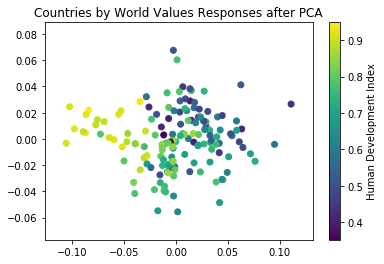

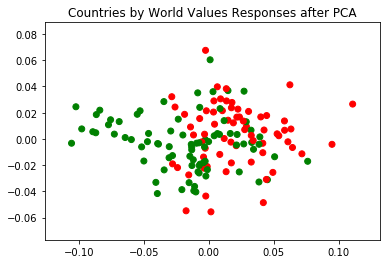

In [5]:
hclasses =[ ut.hdi_classification(x) for x in list(hdi_train['2015'])]

ut.plot_pca(values_train, hdi_train, hclasses )

In [6]:
import world_values_starter as wvs 
from world_values_pipelines import * 
from world_values_parameters import * 

In [7]:
ridge = wvs._rmse_grid_search(values_train, hdi_train, ridge_regression_pipeline,regression_ridge_parameters, 'ridge'  )

RMSE: 0.12303337350607803
Pipeline(memory=None,
     steps=[('ridge', Ridge(alpha=0.02, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])
Coefficients
[[ 0.80823467 -0.74985758 -0.17800015 -1.28408103 -0.66293176 -0.82203172
   0.73733884 -0.92891581 -0.82049672  0.39614952  2.0708291  -0.06718981
   0.48310656  0.72671425  0.42921192 -0.13808023]]



In [8]:
lasso = wvs._rmse_grid_search(values_train, hdi_train,
                lasso_regression_pipeline, regression_lasso_parameters, 'lasso')

RMSE: 0.12602242808947528
Pipeline(memory=None,
     steps=[('lasso', Lasso(alpha=0.0002, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))])
Coefficients
[ 0.1590192  -0.72844929 -0.         -0.85945074 -0.66274144 -0.02556703
  0.33904781 -0.29897158 -0.          0.          3.48536375  0.
  0.          0.87057995  0.32897045 -0.        ]



Yes, lasso gives 6 out of the 16 features 0 weights, while ridge doesnt give any of them 0s. 

## KNN (part h )
You would discretize HDI by binning its values to gives each class to be a range of hdi's. 

In [9]:
# USA nearest neighbors 
import pandas as pd 
from sklearn.neighbors import NearestNeighbors
X = np.array(values_train) 
countries = pd.read_csv('world-values-train2.csv').Country
ref_pnt = X[countries == 'United States', : ] 

X = X[countries != 'United States',:]


nbrs = NearestNeighbors(n_neighbors=8).fit(values_train)
distances, indices = nbrs.kneighbors(values_train.iloc[45].reshape(1, -1))

print("USA's 7 nearest neighbors are (including Itself): ")
print(countries[indices[0]]) 

USA's 7 nearest neighbors are (including Itself): 
45      United States
90            Ireland
61     United Kingdom
37            Belgium
108           Finland
69              Malta
132           Austria
110            France
Name: Country, dtype: object


/home/ymubarak/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  if sys.path[0] == '':


RMSE: 0.11824589460776892
Pipeline(memory=None,
     steps=[('knn', KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=12, p=2,
          weights='uniform'))])


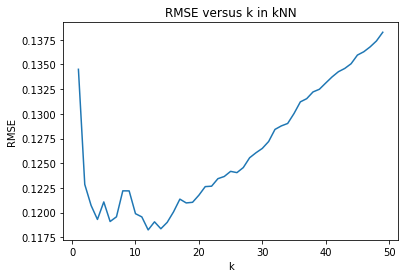

In [10]:
grid = wvs._rmse_grid_search(values_train, hdi_train,
                k_nearest_neighbors_regression_pipeline,
                regression_knn_parameters, 'knn')

The best value of k is 12. The RMSE is 0.12 or 12%. 
As  k increases above 12 the bias decreases, but because variance increases much more, it can't outway the benefit of decreasing bias. That is because we are Choosing too big of a radius to search for points around. We are assuming the neighborhood is too big, hence the complexity increases. In another sense, we are not restricting where our model is looking, like a very low ridge regression lambda. 

RMSE: 0.1171925270311745
Pipeline(memory=None,
     steps=[('knn', KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=14, p=2,
          weights='distance'))])


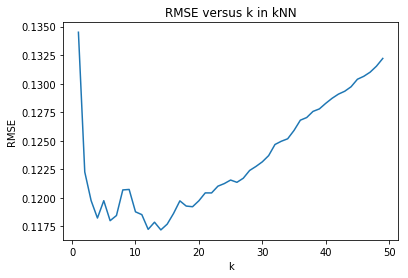

In [11]:
regression_knn_parameters = {
    # 'pca__n_components': np.arange(1, 17),

    'knn__n_neighbors': np.arange(1, 50),

    # Apply distance weighting vs k for k Nearest Neighbors Regression
    'knn__weights': ['distance']
}
grid = wvs._rmse_grid_search(values_train, hdi_train,
                k_nearest_neighbors_regression_pipeline,
                regression_knn_parameters, 'knn')

The best value of k is 14. The RMSE is 0.12 or 12%. 

In [22]:
# USA nearest neighbors 
from sklearn.preprocessing import StandardScaler

import pandas as pd 
#X = np.array(values_train) 
scaler = StandardScaler() 
X = scaler.fit_transform(values_train)
countries = pd.read_csv('world-values-train2.csv').Country

nbrs = NearestNeighbors(n_neighbors=8).fit(X)
distances, indices = nbrs.kneighbors(X[45,:].reshape(1, -1))

print("USA's 7 nearest neighbors are (including Itself): ")
print(countries[indices[0]]) 


USA's 7 nearest neighbors are (including Itself): 
45      United States
90            Ireland
61     United Kingdom
108           Finland
37            Belgium
69              Malta
110            France
132           Austria
Name: Country, dtype: object


RMSE: 0.11488547357936414
Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('knn', KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=3, p=2,
          weights='distance'))])


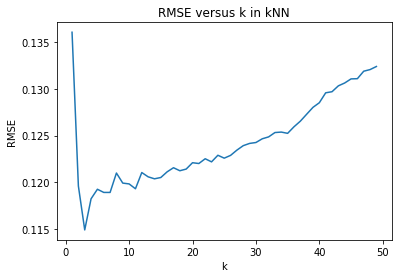

In [13]:
k_nearest_neighbors_regression_pipeline = Pipeline(
        [
            # Apply scaling to k Nearest Neighbors Regression
            ('scale', StandardScaler()),

            ('knn', KNeighborsRegressor())
        ]
    )

grid = wvs._rmse_grid_search(values_train, hdi_train,
                k_nearest_neighbors_regression_pipeline,
                regression_knn_parameters, 'knn')

The best value of k is 3. The RMSE is 0.11 or 11%. 

RMSE: 0.12204044020066376
Pipeline(memory=None,
     steps=[('scale', MaxAbsScaler(copy=True)), ('knn', KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=12, p=2,
          weights='distance'))])


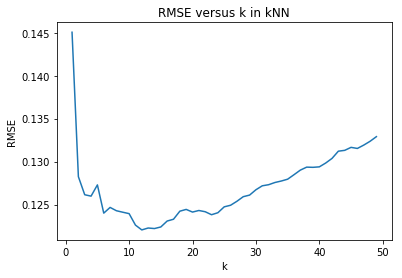


RMSE: 0.12144941346487255
Pipeline(memory=None,
     steps=[('scale', MinMaxScaler(copy=True, feature_range=(0, 1))), ('knn', KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=11, p=2,
          weights='distance'))])


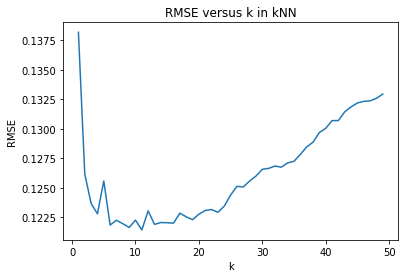


RMSE: 0.11684576848721422
Pipeline(memory=None,
     steps=[('scale', Normalizer(copy=True, norm='l2')), ('knn', KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=15, p=2,
          weights='distance'))])


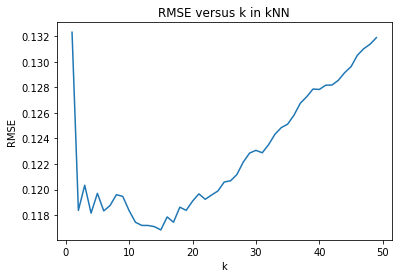


RMSE: 0.11683134000136783
Pipeline(memory=None,
     steps=[('scale', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('knn', KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=11, p=2,
          weights='distance'))])


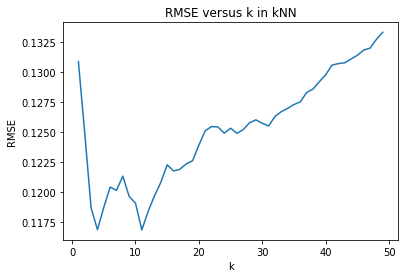

In [14]:
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler, Normalizer , RobustScaler 
scalers = [MaxAbsScaler, MinMaxScaler, Normalizer, RobustScaler]
for s in scalers : 
    k_nearest_neighbors_regression_pipeline = Pipeline(
        [
            # Apply scaling to k Nearest Neighbors Regression
            ('scale', s()),

            ('knn', KNeighborsRegressor())
        ]
    )

    grid = wvs._rmse_grid_search(values_train, hdi_train,
                k_nearest_neighbors_regression_pipeline,
                regression_knn_parameters, 'knn')
    

It doesn't seem to help at all, since the unit variance and mean seems to give the most decrease in RMSE and the least neighbors needed to search for. 

RMSE: 0.11488547357936414
Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('knn', KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=3, p=2,
          weights='distance'))])


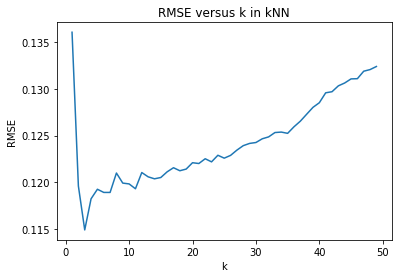


[[0.5109997 ]
 [0.61570753]
 [0.68331113]
 [0.67852229]
 [0.7718753 ]
 [0.60419024]
 [0.65159897]
 [0.67945579]
 [0.73105346]
 [0.8053592 ]
 [0.67938174]
 [0.66520881]
 [0.7793257 ]
 [0.70584762]
 [0.66568196]
 [0.56691101]
 [0.69252235]
 [0.72706267]
 [0.70498736]
 [0.77513888]
 [0.63384268]
 [0.65089538]
 [0.39709827]
 [0.73442026]
 [0.7583716 ]
 [0.71157266]
 [0.44080564]
 [0.90460366]
 [0.62818537]
 [0.65208228]
 [0.6630599 ]
 [0.86539214]
 [0.72870152]
 [0.90989302]
 [0.924362  ]
 [0.8432591 ]
 [0.49853809]
 [0.80810577]]


In [15]:
k_nearest_neighbors_regression_pipeline = Pipeline(
        [
            # Apply scaling to k Nearest Neighbors Regression
            ('scale', StandardScaler()),

            ('knn', KNeighborsRegressor())
        ]
    )

grid = wvs._rmse_grid_search(values_train, hdi_train,
                k_nearest_neighbors_regression_pipeline,
                regression_knn_parameters, 'knn')
print(grid.predict(values_test))

# Classification (S) 

According the plot, svm will not do very well because there doesn't seem to be a clear linear seperation between the high and low HDI classes. 

In [16]:
svm= wvs._accuracy_grid_search(values_train, hclasses,
                        svm_classification_pipeline,
                        classification_svm_parameters)

Accuracy: 0.75
Pipeline(memory=None,
     steps=[('svm', SVC(C=48.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])



In [17]:
svm_classification_pipeline = Pipeline( [('scaling',StandardScaler()),('pca', PCA()),('svm', SVC())])
classification_svm_parameters = {'svm__kernel': ['linear'],'svm__C': np.arange(1.0, 100.0, 1.0)}

svm= wvs._accuracy_grid_search(values_train, hclasses,
                        svm_classification_pipeline,
                        classification_svm_parameters)

Accuracy: 0.7027027027027027
Pipeline(memory=None,
     steps=[('scaling', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('svm', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])



there is a 5% decrease in accuracy. 

In [18]:
svm_classification_pipeline = Pipeline( [('scaler',StandardScaler()),('svm', SVC())])
classification_svm_parameters = {'svm__kernel': ['rbf'],'svm__C': np.arange(1.0, 100.0, 1.0)}

svm= wvs._accuracy_grid_search(values_train, hclasses,
                        svm_classification_pipeline,
                        classification_svm_parameters)


Accuracy: 0.777027027027027
Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm', SVC(C=2.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])



The accuracy increases noticeably to 77%. 

In [19]:
classification_knn_parameters = {'knn__n_neighbors': np.arange(1, 50),'knn__weights': ['distance']}

knn= wvs._accuracy_grid_search(values_train, hclasses,
                        k_nearest_neighbors_classification_pipeline,
                        classification_knn_parameters)


Accuracy: 0.7635135135135135
Pipeline(memory=None,
     steps=[('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=4, p=2,
           weights='distance'))])



In [20]:
classification_knn_parameters = {'knn__n_neighbors': np.arange(1, 50),'knn__weights': ['distance']}

k_nearest_neighbors_classification_pipeline = Pipeline(
        [('scale', StandardScaler()),('knn', KNeighborsClassifier())
        ]
    )
knn= wvs._accuracy_grid_search(values_train, hclasses,
                        k_nearest_neighbors_classification_pipeline,
                        classification_knn_parameters)


Accuracy: 0.7702702702702703
Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=4, p=2,
           weights='distance'))])



scaling helps by around 1% accuracy. 

# Part Z 
I think its a very useful problem because we learn to use scikitlearn and outside architecture packages to solve standard machine learning problems. I also like its application to social sciences instead of the standard EECS problems.